![](./images/Title_ex_6.4.2.png)

# 1. Introduction
The FAO Water Productivity Open-access portal (WaPOR) is a public and free available database that contains earth observation products to monitor agricultural water productivity over Africa. The product portfolio contains information on weather conditions (e.g. Precipitation), water availability (e.g. Evapotranspiration) and land charachteristics (e.g. Land Cover and Primary/Biomass Production). The datasets are available from 2009 onwards at three different levels: 
- Level I at continental level (250 m ground resolution): Africa & Middle East
- Level II at country and river basin level (100 m ground resolution): Selection of African countries
- Level III at irrigation scheme and sub-basin level (30 m ground resolution): Selection 
More information on the WaPOR database and data availability can be found here: 
https://wapor.apps.fao.org/catalog/WAPOR_2/1

The WaPOR database can be accessed via webservices. In this excercise we will explore API acccess via a Jupyter Notebook. More explanation and examples can be found here: https://github.com/wateraccounting/WAPORWP 


The two WaPOR products which we will investigate in this Notebook are Net Primary Production (NPP) and Total Biomass Production (TBP). 
- Net Primary Production (NPP) is a fundamental ecosystem variable that represent the part of Gross Primary Production (GPP or photosynthesis) that is available for biomass growth. In WaPOR it is derived from a Light Use Efficiency (LUE) model that combines information on fAPAR, solar radiation and temperature. To account for drought stressed NPP, a soil moisture reduction factor is added to the model. NPP is available at 10-daily timestep and can be used to track seasonal dynamics of biomass production.
- Total biomass production (TBP) is defined as the sum of the dry matter produced during the growing season. The delineation of the growing season is derived at pixel level from time series of satellite based vegetation indices. TBP can be related to seasonal crop production or pasture availability. 

The detailed product and algorithm description is provided in the Methodology Report of WaPOR (Chapter 2.1.6, avialable here https://www.fao.org/3/ca9894en/CA9894EN.pdf). 


# 2. Loading libraries

In [26]:
import requests
import pandas as pd
import os
import matplotlib.pyplot as plt

# 2. General exploration of FAO workspace & WAPOR catalog
## 2.1 Exploration of available FAO workspaces
We will first connect to the FAO webservices, select the WAPOR catalog and explore the products. 

In [27]:
#In this cell a connection is made to the FAO API services and a list is printed of all available workspaces. 

workspace='WAPOR_2'

overview=False
paged=False
overview=False
paged=False
url_workspaces= f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces?overview={overview}&paged={paged}'
resp_workspaces=requests.get(url_workspaces) #Get response
resp_dict_workspaces=resp_workspaces.json() #read response JSON string 
df_workspaces=pd.DataFrame.from_dict(resp_dict_workspaces['response'])
df_workspaces

,code,caption,description,links,additionalInfo,tags
0,AQUAMAPS,Global spatial database on water and agriculture,Regional and global spatial datasets on water ...,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN,NaN
1,ASIS,Agriculture Stress Index System,ASIS allows countries to fine-tune parameters ...,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN,NaN
2,C2ATLAS,Climate Change ATLAS,C2ATLAS (Climate Change ATLAS - CSIC).The Clim...,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN,NaN
3,C3S,Copernicus Climate Change Service,The Copernicus Climate Change Service (C3S) wi...,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN,NaN
4,CHIRPS,Climate Hazard group InfraRed Precipitation wi...,Climate Hazard group InfraRed Precipitation wi...,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN,NaN
5,CROPWATCH,CropWatch,Cropwatch is China's leading agricultural moni...,"[{'rel': 'self', 'href': 'https://io.apps.fao....","{'creationDate': '1998-01-01', 'link': 'https:...",[{'name': 'CROP'}]
6,CRTB,Climate Risk Toolbox (CRTB),Climate Risk Toolbox (CRTB),"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN,"[{'name': 'CRTB'}, {'name': 'ASSESSMENT'}, {'n..."
7,DLMF,Desert Locust Monitoring and Forecasting,DLMF-Desert Locust monitoring and forecasting....,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN,[{'name': 'LOCUST'}]
8,FAOSTAT,FAO Corporate Statistical Database,FAOSTAT provides free access to food and agric...,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN,NaN
9,FROM_GLC,Finer Resolution Observation and Monitoring of...,Global land cover data are key sources of info...,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN,[{'name': 'LCC'}]


## 2.1 WAPOR Catalog exploration
Next we will list all available products in the WaPOR catalog.

In [30]:
# This cell prints an overview of the first products and writes the entire list of products to a CSV file. 

workspace='WAPOR_2'
overview=False
paged=False

url_catalog= f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes?overview={overview}&paged={paged}'
resp_catalog=requests.get(url_catalog).json()
df_catalog=pd.DataFrame.from_dict(resp_catalog['response'])
outdir = './results'
if not os.path.exists(outdir):
    os.mkdir(outdir)
df_catalog.to_csv(f'./results/{workspace}.csv')
df_catalog


,code,caption,description,additionalInfo,tags,workspaceCode,dataType,index,operation,hidden,links
0,L1_GBWP_A,Gross Biomass Water Productivity,The annual Gross Biomass Water Productivity ex...,"{'format': 'Raster Dataset', 'unit': 'kg/m³ is...","[{'name': 'L1', 'index': 1, 'context': 'LEVELS...",WAPOR_2,RASTER,101,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
1,L1_NBWP_A,Net Biomass Water Productivity,The annual Net Biomass Water Productivity expr...,"{'format': 'Raster Dataset', 'unit': 'kg/m³ is...","[{'name': 'L1', 'index': 2, 'context': 'LEVELS...",WAPOR_2,RASTER,102,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
2,L1_AETI_A,Actual EvapoTranspiration and Interception (An...,The actual EvapoTranspiration and Interception...,"{'format': 'Raster Dataset', 'unit': 'mm', 'da...","[{'name': 'L1', 'index': 3, 'context': 'LEVELS...",WAPOR_2,RASTER,103,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
3,L1_AETI_M,Actual EvapoTranspiration and Interception (Mo...,The actual EvapoTranspiration and Interception...,"{'format': 'Raster Dataset', 'unit': 'mm', 'da...","[{'name': 'L1', 'index': 4, 'context': 'LEVELS...",WAPOR_2,RASTER,104,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
4,L1_AETI_D,Actual EvapoTranspiration and Interception (De...,The actual EvapoTranspiration and Interception...,"{'format': 'Raster Dataset', 'unit': 'mm', 'da...","[{'name': 'L1', 'index': 5, 'context': 'LEVELS...",WAPOR_2,RASTER,105,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
...,...,...,...,...,...,...,...,...,...,...,...
280,L3_GEZ_QUAL_NDVI_LT,Quality of Normalized Difference Vegetation In...,The long-term NDVI quality layer is produced a...,"{'format': 'Raster Dataset', 'unit': '%', 'dat...","[{'name': 'L3', 'index': 270, 'context': 'LEVE...",WAPOR_2,RASTER,30270,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
281,L3_KOG_QUAL_NDVI_LT,Quality of Normalized Difference Vegetation In...,The long-term NDVI quality layer is produced a...,"{'format': 'Raster Dataset', 'unit': '%', 'dat...","[{'name': 'L3', 'index': 271, 'context': 'LEVE...",WAPOR_2,RASTER,30271,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
282,L3_LAM_QUAL_NDVI_LT,Quality of Normalized Difference Vegetation In...,The long-term NDVI quality layer is produced a...,"{'format': 'Raster Dataset', 'unit': '%', 'dat...","[{'name': 'L3', 'index': 273, 'context': 'LEVE...",WAPOR_2,RASTER,30273,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
283,L3_ODN_QUAL_NDVI_LT,Quality of Normalized Difference Vegetation In...,The long-term NDVI quality layer is produced a...,"{'format': 'Raster Dataset', 'unit': '%', 'dat...","[{'name': 'L3', 'index': 276, 'context': 'LEVE...",WAPOR_2,RASTER,30276,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."


## 2.2 WAPOR Catalog filtering
Next we will filter the WaPOR catalog for products that contain either NPP or TBP. The list of remaining products contains the products from three levels L1_ (250m continental), L2_ (100m national) & L3_ (30m areas). 

In [31]:
filter_lst = ['NPP','TBP']


filter_str  = '|'.join([str(elem) for elem in filter_lst])
filter_fn_str  = '_'.join([str(elem) for elem in filter_lst])

df_catalog_filtered = (df_catalog[df_catalog['code'].str.contains(filter_str)])
df_catalog_filtered.to_csv(f'./results/{workspace}_{filter_fn_str}.csv')
df_catalog_filtered

,code,caption,description,additionalInfo,tags,workspaceCode,dataType,index,operation,hidden,links
11,L1_NPP_M,Net Primary Production (Monthly),Net Primary Production (NPP) is a fundamental ...,"{'format': 'Raster Dataset', 'unit': 'gC/m²', ...","[{'name': 'L1', 'index': 12, 'context': 'LEVEL...",WAPOR_2,RASTER,112,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
12,L1_NPP_D,Net Primary Production (Dekadal),Net Primary Production (NPP) is a fundamental ...,"{'format': 'Raster Dataset', 'unit': 'gC/m²', ...","[{'name': 'L1', 'index': 12, 'context': 'LEVEL...",WAPOR_2,RASTER,112,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
13,L1_TBP_A,Total Biomass Production (Annual),The annual Total Biomass Production expresses ...,"{'format': 'Raster Dataset', 'unit': 'kg/ha', ...","[{'name': 'L1', 'index': 13, 'context': 'LEVEL...",WAPOR_2,RASTER,113,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
36,L2_NPP_M,Net Primary Production (Monthly),Net Primary Production (NPP) is a fundamental ...,"{'format': 'Raster Dataset', 'unit': 'gC/m²', ...","[{'name': 'L2', 'index': 12, 'context': 'LEVEL...",WAPOR_2,RASTER,212,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
37,L2_NPP_D,Net Primary Production (Dekadal),Net Primary Production (NPP) is a fundamental ...,"{'format': 'Raster Dataset', 'unit': 'gC/m²', ...","[{'name': 'L2', 'index': 12, 'context': 'LEVEL...",WAPOR_2,RASTER,212,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
38,L2_TBP_S,Total Biomass Production (Seasonal),Total Biomass Production (TBP) is defined as t...,"{'format': 'Raster Dataset', 'unit': 'kg/ha', ...","[{'name': 'L2', 'index': 13, 'context': 'LEVEL...",WAPOR_2,RASTER,213,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
189,L3_AWA_NPP_M,"Net Primary Production (Awash, Ethiopia - Mont...",Net Primary Production (NPP) is a fundamental ...,"{'format': 'Raster Dataset', 'unit': 'gC/m²', ...","[{'name': 'L3', 'index': 155, 'context': 'LEVE...",WAPOR_2,RASTER,30155,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
190,L3_BKA_NPP_M,"Net Primary Production (Bekaa, Lebanon - Monthly)",Net Primary Production (NPP) is a fundamental ...,"{'format': 'Raster Dataset', 'unit': 'gC/m²', ...","[{'name': 'L3', 'index': 156, 'context': 'LEVE...",WAPOR_2,RASTER,30156,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
191,L3_BUS_NPP_M,"Net Primary Production (Busia, Kenya - Monthly)",Net Primary Production (NPP) is a fundamental ...,"{'format': 'Raster Dataset', 'unit': 'gC/m²', ...","[{'name': 'L3', 'index': 157, 'context': 'LEVE...",WAPOR_2,RASTER,30157,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
192,L3_GEZ_NPP_M,"Net Primary Production (Gezira, Sudan - Monthly)",Net Primary Production (NPP) is a fundamental ...,"{'format': 'Raster Dataset', 'unit': 'gC/m²', ...","[{'name': 'L3', 'index': 158, 'context': 'LEVE...",WAPOR_2,RASTER,30158,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."


## 2.3 WAPOR product selection & meta-data exploration
We will select the Level 1 product of dekadal NPP (L1_NPP_D) and look at the associated meta-data.

In [5]:
#This cell prints the meta-data in the original dictionary format. 

catalog_code='L1_NPP_D'

workspace='WAPOR_2'
url_catalog=f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes/{catalog_code}'
resp_code=requests.get(url_catalog).json()
resp_code

{'requestId': 'b3400d83-f7f5-464f-ba4e-9d776f6be55b',
 'timestamp': 1663068222089,
 'runtime': 3,
 'status': 200,
 'message': 'OK',
 'response': {'code': 'L1_NPP_D',
  'caption': 'Net Primary Production (Dekadal)',
  'description': 'Net Primary Production (NPP) is a fundamental characteristic of an ecosystem, expressing the conversion of carbon dioxide into biomass driven by photosynthesis. The pixel value represents the mean daily NPP for that specific dekad.',
  'additionalInfo': {'format': 'Raster Dataset',
   'unit': 'gC/m²',
   'dataType': 'Int16 (16bit Integer)',
   'conversionFactor': 'the pixel value in the downloaded data must be multiplied by 0.001',
   'noDataValue': -9999,
   'spatialResolution': '250m (0.00223 degree)',
   'spatialExtent': 'Africa and Near East',
   'spatialReferenceSystem': 'EPSG:4326 - WGS84 - Geographic Coordinate System (lat/long)',
   'temporalResolution': 'from January 2009 to present',
   'temporalExtent': 'Dekadal (approximately every 10 days)',
  

Meta-data publication

In [6]:
#This cell prints the key charactersitics from the meta-data dictionary in a more structured manner. 

print('################# Thematic Details ###################################')
print('Code                        : ',resp_code['response']['code'])
print('Variable                    : ',resp_code['response']['caption'])
print('Description                 : ',resp_code['response']['description'])
print('Unit                        : ',resp_code['response']['additionalInfo']['unit'])
print('')
print('################# Data Type & Scaling ################################')
print('Data Type                   : ',resp_code['response']['additionalInfo']['dataType'])
print('conversion Factor           : ',resp_code['response']['additionalInfo']['conversionFactor'])
print('No Data Value               : ',resp_code['response']['additionalInfo']['noDataValue'])
print('')
print('################# Coverage & Spatial Information ######################')
print('Coverage                    : ',resp_code['response']['additionalInfo']['spatialExtent'])
print('Spatial Resolution          : ',resp_code['response']['additionalInfo']['spatialResolution'])
print('Reference system            : ',resp_code['response']['additionalInfo']['spatialReferenceSystem'])
print('')
print('################# Archive Availability & Periodicity ##################')
print('Periodicity                 : ',resp_code['response']['additionalInfo']['temporalResolution'])
print('Archive Availability        : ',resp_code['response']['additionalInfo']['temporalExtent'])
print('Near Real Time Availibility : ',resp_code['response']['additionalInfo']['nearRealTime'])
print('################# Methodology ##################')
print('Methodology                 : ',resp_code['response']['additionalInfo']['methodology'])


################# Thematic Details ###################################
Code                        :  L1_NPP_D
Variable                    :  Net Primary Production (Dekadal)
Description                 :  Net Primary Production (NPP) is a fundamental characteristic of an ecosystem, expressing the conversion of carbon dioxide into biomass driven by photosynthesis. The pixel value represents the mean daily NPP for that specific dekad.
Unit                        :  gC/m²

################# Data Type & Scaling ################################
Data Type                   :  Int16 (16bit Integer)
conversion Factor           :  the pixel value in the downloaded data must be multiplied by 0.001
No Data Value               :  -9999

################# Coverage & Spatial Information ######################
Coverage                    :  Africa and Near East
Spatial Resolution          :  250m (0.00223 degree)
Reference system            :  EPSG:4326 - WGS84 - Geographic Coordinate System (lat/lo

# 3. Net Primary Production  (NPP) time series extraction

Now that we have explored the product details we will extract and plot a time series of dekadal NPP data for a specific location. 

Use the following function to download a time series for a single pixel:

In [7]:
def get_pixel_timeseries(workspace, product_code,
                         coordinates, crs,
                         start_date, end_date):
    '''
    Function to extract one or multiple pixel time series from the FAO portal.
    Parameters:
    - workspace: workspace in the FAO catalog where the product of interest is located.
    - product_code: specific product you wish to download.
    - coordinates: dictionary with keys representing label of the point
        and values the x,y coordinate pair in the CRS defined by the next parameter.
        In case of Geographic CRS, the order should be [lat, lon].
    - crs: EPSG code of projection system (int)
    - start_date: start date of the time series.
        Should be str in the following format: "yyyy-mm-dd".
    - end_date: end date of the time series.
        Should be str in the following format: "yyyy-mm-dd".
        
    The function will return a dataframe with time as index and each column
    representing the query result for an individual point.
    '''
    
    print('Making some preparations...')
    
    path_query = r'https://io.apps.fao.org/gismgr/api/v1/query/'
    
    crs = f'EPSG:{crs}'
    
    # get datacube measure
    cube_url = f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes/{product_code}/measures'
    resp = requests.get(cube_url).json()
    measure = resp['response']['items'][0]['code']
    print('MEASURE: ', measure)
    
    # get datacube time dimension
    cube_url = f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes/{product_code}/dimensions'
    resp = requests.get(cube_url).json()
    items = pd.DataFrame.from_dict(resp['response']['items'])
    dimension = items[items.type=='TIME']['code'].values[0]
    print('DIMENSION: ', dimension)
    
    print('Sending query for each point...')
    npoints = len(coordinates.keys())
    i = 0    
    for label, coo in coordinates.items():
        
        print(f'Processing point {i+1} / {npoints}...')
        query = {
        "type": "PixelTimeSeries",
        "params": {
            "cube": {
            "code": product_code,
            "workspaceCode": workspace,
            "language": "en"
            },
            "dimensions": [
            {
                "code": dimension,
                "range": f"[{start_date},{end_date})"
            }
            ],
            "measures": [
            measure
            ],
            "point": {
            "crs": crs,            
            "x":coo[1],
            "y":coo[0]
            }
        }
        }
        
        resp_query = requests.post(path_query, json=query)
        resp = resp_query.json()
        results = resp['response']
        df = pd.DataFrame(results['items'], columns=['Time', label])
        df.index = pd.to_datetime(df['Time'], format='%Y-%m-%d')
        df = df.drop(columns=['Time'])
        if i == 0:
            df_fin = df
        else:
            df_fin = pd.merge(df_fin, df, left_index=True, right_index=True)  
        
        i += 1
        print('Query successful!')
        
    return df_fin

In [10]:
# Specify parameters for API query
point = {"test": [14.801460,-13.616014]}
# coordinate reference system
crs = 4326 
product_code = "L1_NPP_D"
workspace = 'WAPOR_2'
start_date = "2009-01-01"
end_date = "2009-12-31"

output = get_pixel_timeseries(workspace, product_code,
                              point, crs,
                              start_date, end_date)
output.head()

Making some preparations...
MEASURE:  NPP
DIMENSION:  DEKAD
Sending query for each point...
Processing point 1 / 1...
Query successful!


,test
Time,
2009-01-10,0.413
2009-01-20,0.304
2009-01-31,0.190
2009-02-10,0.167
2009-02-20,0.171


## 3.2 Plot time series
Based on the Pandas dataframe the NPP time series is visualized in a line graph. Execute the cell and interpret the time series for your point. Have a look at the unit of the axis and the absolute values. Is there a clear growing season present? Is there a period with zero NPP? When is the peak and what does this mean? 

Text(0.5, 1.0, 'NPP time series example')

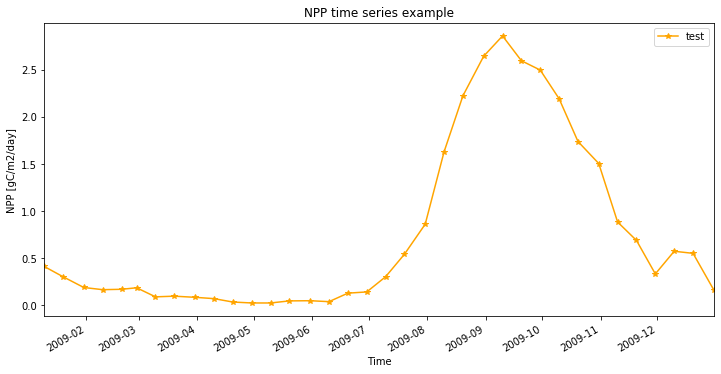

In [11]:
#Cell that generates a line graph from the Pandas dataframe. 

figs, ax = plt.subplots(1, figsize=(12, 6))

output.plot(ax=ax, color='orange', marker='*')
ax.set_ylabel('NPP [gC/m2/day]')
ax.legend(loc='upper right', ncol=5)
ax.set_title('NPP time series example')

# 3. NPP product time series exploration
The previous extraction was focused on a single location. Next we will run a script for multiple locations or pixel extractions and visualize the outputs. 

In [17]:
#Define a dictionary of geo-locations in Lat/Lon coordinates. 
#You can give each pixel a name that will be used in the time series plot. 
#The extraction can take a few moments (usually < 2 min)

points_dict = {'Nigeria_south_agriculture': [6.408084,6.240997],
               'Nigeria_south_forest':[6.472100,6.271589],
               'Nigeria_north_agriculture':[7.195370,11.562504],
               'Nigeria_north_forest':[6.990481,11.628498]}

crs = 4326  # lat/lon
product_code = "L1_NPP_D"
workspace = 'WAPOR_2'

start_date = '2015-01-01'
end_date = '2017-12-31'

output = get_pixel_timeseries(workspace, product_code,
                              points_dict, crs,
                              start_date, end_date)
output.head()

Making some preparations...
MEASURE:  NPP
DIMENSION:  DEKAD
Sending query for each point...
Processing point 1 / 4...
Query successful!
Processing point 2 / 4...
Query successful!
Processing point 3 / 4...
Query successful!
Processing point 4 / 4...
Query successful!


,Nigeria_south_agriculture,Nigeria_south_forest,Nigeria_north_agriculture,Nigeria_north_forest
Time,,,,
2015-01-10,2.981,2.739,2.755,3.680
2015-01-20,2.605,2.304,2.339,3.837
2015-01-31,1.706,1.448,1.613,3.145
2015-02-10,1.523,1.192,1.341,2.629
2015-02-20,1.479,1.079,1.360,2.185


Text(0.5, 1.0, 'NPP time series example')

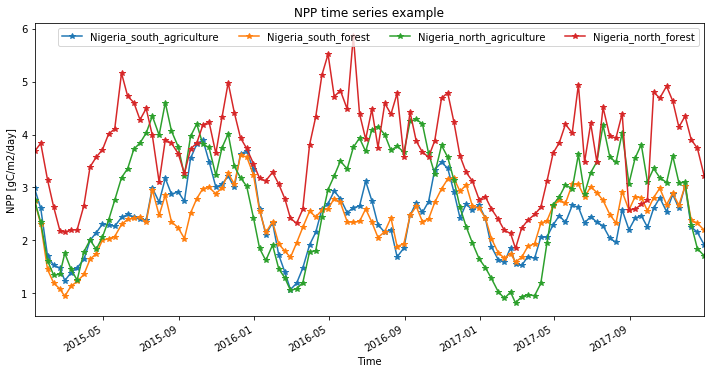

In [18]:
# Plot all time series and interpret the outcomes:
# - Are there big differences amongst the locations? And can you explain them?
# - Which is the most productive and least productive site? 

figs, ax = plt.subplots(1, figsize=(12, 6))
output.plot(ax=ax, marker='*')
ax.set_ylabel('NPP [gC/m2/day]')
ax.legend(loc='upper right', ncol=5)
ax.set_title('NPP time series example')

# 4. Total Biomass Production (TBP) product exploration

In [19]:
# This cell prints the key charactersitics from the meta-data dictionary in a more structured manner. 
# The TBP meta-data does not contain information on the conversion factor. 
#Based on the WaPOR documentation we know that the digital values represent the physical values in kg DM/ha. 
#So slope = 1 and offset = 0 in this case.


catalog_code = 'L1_TBP_A'
workspace = 'WAPOR_2'
url_catalog = f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes/{catalog_code}'
resp_code = requests.get(url_catalog).json()

print('################# Thematic Details ###################################')
print('Code                        : ',resp_code['response']['code'])
print('Variable                    : ',resp_code['response']['caption'])
print('Description                 : ',resp_code['response']['description'])
print('Unit                        : ',resp_code['response']['additionalInfo']['unit'])
print('')
print('################# Data Type & Scaling ################################')
print('Data Type                   : ',resp_code['response']['additionalInfo']['dataType'])
print('No Data Value               : ',resp_code['response']['additionalInfo']['noDataValue'])
print('')
print('################# Coverage & Spatial Information ######################')
print('Coverage                    : ',resp_code['response']['additionalInfo']['spatialExtent'])
print('Spatial Resolution          : ',resp_code['response']['additionalInfo']['spatialResolution'])
print('Reference system            : ',resp_code['response']['additionalInfo']['spatialReferenceSystem'])
print('')
print('################# Archive Availability & Periodicity ##################')
print('Periodicity                 : ',resp_code['response']['additionalInfo']['temporalResolution'])
print('Archive Availability        : ',resp_code['response']['additionalInfo']['temporalExtent'])
print('Near Real Time Availibility : ',resp_code['response']['additionalInfo']['nearRealTime'])
print('################# Methodology ##################')
print('Methodology                 : ',resp_code['response']['additionalInfo']['methodology'])

################# Thematic Details ###################################
Code                        :  L1_TBP_A
Variable                    :  Total Biomass Production (Annual)
Description                 :  The annual Total Biomass Production expresses the total amount of dry matter produced over the year. It is calculated by dekad and summarized as annual total. Each pixel represents the annual amount of dry matter in kg per hectare.
Unit                        :  kg/ha

################# Data Type & Scaling ################################
Data Type                   :  Int32 (32bit Integer)
No Data Value               :  -9999

################# Coverage & Spatial Information ######################
Coverage                    :  Africa and Near East
Spatial Resolution          :  250m (0.00223 degree)
Reference system            :  EPSG:4326 - WGS84 - Geographic Coordinate System (lat/long)

################# Archive Availability & Periodicity ##################
Periodicity         

In [21]:
# Specify parameters for API query
points = {'point1': [7.89534, 37.95883206252312],
         'point2': [14.801460, -13.616014]}
# coordinate reference system
crs = 4326 

product_code = "L1_TBP_A"
workspace = 'WAPOR_2'

start_date = "2009-01-01"
end_date = "2018-12-31"

output = get_pixel_timeseries(workspace, product_code,
                              points, crs,
                              start_date, end_date)
output.head()

Making some preparations...
MEASURE:  LPR
DIMENSION:  YEAR
Sending query for each point...
Processing point 1 / 2...
Query successful!
Processing point 2 / 2...
Query successful!


,point1,point2
Time,,
2009-01-01,25992.0,6124.0
2010-01-01,23882.0,5348.0
2011-01-01,23708.0,4225.0
2012-01-01,23737.0,5925.0
2013-01-01,22298.0,4565.0


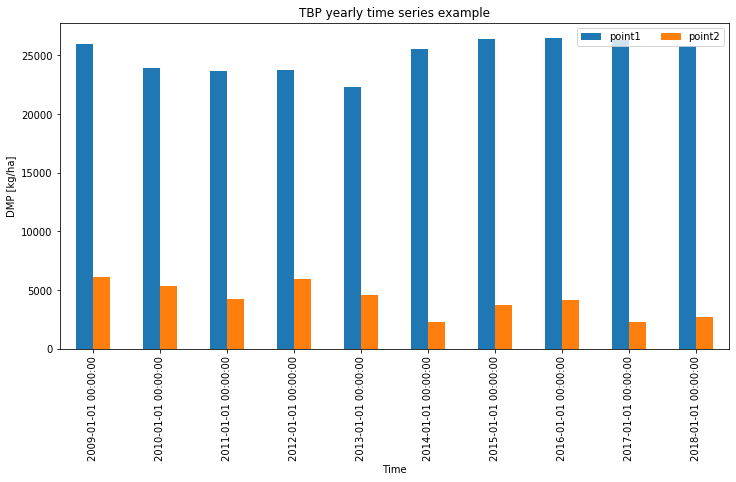

In [24]:
# Visualize yearly TBP values and interpret the inter-annual differences.
# How productive is your selected site? Which factor do you need to apply to convert to ton per hectare?
# Which years are most and least productive? What could be underlying factors? Think about weather conditions, drought, precipitation,...
# On agricultural sites also crop rotation and management practices can play an important role.

figs, ax = plt.subplots(1, figsize=(12, 6))
output.plot.bar(ax=ax)
ax.set_ylabel('DMP [kg/ha]')
ax.legend(loc='upper right', ncol=5)
ax.set_title('TBP yearly time series example')
plt.show()
